<a href="https://colab.research.google.com/github/seunval/Supervised-Learning-project-3MTT/blob/main/CV_Hands_On.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing necessary libraries
import pandas as pd
import numpy as np
import re
import os


In [ ]:
#define a regular expression for each category
soup_pattern = r"\b(amala|afang|soup|stew)\b"
rice_pattern = r"\b(jollof|fried|rice|friedrice|ofada)\b"
spaghetti_pattern = r"\b(spaghetti|spag|Macaroni|Pasta)\b"
yam_pattern = r"\b(yam)\b"
fruit_pattern = r"\b(soursop|tangerine|apples|lemon|cucumber|oranges|african pear|watermelon|banana|dragon fruit|cashew-fruit|cabbage|prickly pears|mangosteen|avocado|cherry|starfruit|papaya|apple|orange|banana|mango|strawberry|grapes|pineapple|guava|pomegranate|kiwi)\b"


# Define a function to categorize food based on the filename
def categorize_food(item):
    if re.search(yam_pattern, item, re.IGNORECASE):
        return 'Yam'
    elif re.search(rice_pattern, item, re.IGNORECASE):
        return 'Rice'
    elif re.search(soup_pattern, item, re.IGNORECASE):
        return 'Soup'
    elif re.search(spaghetti_pattern, item, re.IGNORECASE):
        return 'Spaghetti'
    elif re.search(fruit_pattern, item, re.IGNORECASE):
        return 'Fruit'
    else:
        return 'Other'

In [ ]:
#where all the files are located
data_path = '/content/drive/MyDrive/3MTT Data'

In [ ]:
#looping through all the filename to get the category
data = []

for filename in os.listdir(data_path):
  category = categorize_food(filename)
  data.append([filename, category])

In [ ]:
# data

In [ ]:
#converting it to a dataframe
df = pd.DataFrame(data, columns = ['Filename', 'Category'])

In [ ]:
df.head()

,Filename,Category
0,Afang soup - Peter Aluko (Seunval) (2).jpeg,Soup
1,akara - Peter Aluko (Seunval).jpg,Other
2,amala and efo riro - Peter Aluko (Seunval).jpg,Soup
3,Amala and Ewedu - Peter Aluko (Seunval).jpg,Soup
4,amala and gbegiri - Peter Aluko (Seunval).jpeg,Soup


In [ ]:
df.Category.value_counts()

Spaghetti    74
Yam          52
Other        51
Rice         43
Fruit        32
Soup         12
Name: Category, dtype: int64

In [ ]:
desired_categories = ['Spaghetti', 'Yam', 'Rice', 'Fruit', 'Soup']

In [ ]:
#pick only selected catergories to train on
new_df = df[df.Category.isin(desired_categories)]
new_df.shape

(213, 2)

In [ ]:
new_df.Category.unique()

array(['Soup', 'Rice', 'Fruit', 'Spaghetti', 'Yam'], dtype=object)

In [ ]:
#necessary libraries
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
images_dir = data_path

In [ ]:
# data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

In [ ]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=new_df,
    directory=images_dir,  # replace with your actual images directory
    x_col='Filename',
    y_col='Category',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed = 42)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=new_df,
    directory=images_dir,  # replace with your actual images directory
    x_col='Filename',
    y_col='Category',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed = 42)

Found 132 validated image filenames belonging to 5 classes.
Found 33 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 48 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 48 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
train_generator

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout

In [ ]:
#the CNN configuration
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [ ]:
#compiling the model before training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#training the model
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator
)

Epoch 1/10
9/9 [==============================] - 21s 2s/step - loss: 2.2082 - accuracy: 0.2727 - val_loss: 1.6865 - val_accuracy: 0.0303
Epoch 2/10
9/9 [==============================] - 12s 1s/step - loss: 1.4918 - accuracy: 0.3258 - val_loss: 2.1538 - val_accuracy: 0.0303
Epoch 3/10
9/9 [==============================] - 12s 1s/step - loss: 1.3681 - accuracy: 0.4167 - val_loss: 2.0099 - val_accuracy: 0.0303
Epoch 4/10
9/9 [==============================] - 14s 2s/step - loss: 1.4731 - accuracy: 0.2727 - val_loss: 1.7673 - val_accuracy: 0.0303
Epoch 5/10
9/9 [==============================] - 12s 1s/step - loss: 1.4612 - accuracy: 0.3788 - val_loss: 1.9895 - val_accuracy: 0.0303
Epoch 6/10
9/9 [==============================] - 12s 1s/step - loss: 1.4134 - accuracy: 0.3409 - val_loss: 2.0070 - val_accuracy: 0.0606
Epoch 7/10
9/9 [==============================] - 14s 2s/step - loss: 1.4207 - accuracy: 0.3409 - val_loss: 2.1500 - val_accuracy: 0.0303
Epoch 8/10
9/9 [==================

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")


3/3 [==============================] - 1s 281ms/step - loss: 2.2243 - accuracy: 0.2121
Validation loss: 2.2242543697357178
Validation accuracy: 0.21212121844291687


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image_category(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_array_expanded_dims / 255.0

    # Make a prediction
    prediction = model.predict(img_preprocessed)

    # Assuming your model's classes are accessible via train_generator.class_indices
    # which is a dictionary mapping class names to their indices.
    # We need to invert this dictionary to map indices back to class names.
    label_map = dict((v, k) for k, v in train_generator.class_indices.items())

    # Find the index of the maximum score in the prediction array
    predicted_class_index = np.argmax(prediction, axis=1)
    predicted_class_name = label_map[predicted_class_index[0]]

    return predicted_class_name

# # Example usage
# image_path = 'path/to/your/image.jpg'
# predicted_category = predict_image_category(image_path, model)
# print(f"The predicted category is: {predicted_category}")


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def display_image_with_prediction(image_path, model):
    # Predict the image category
    predicted_category = predict_image_category(image_path, model)

    # Load the image for display
    img = image.load_img(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks

    # Add a rectangle for the text background, if desired
    plt.gca().add_patch(Rectangle((0, 0), 120, 30, color='white'))

    # Add the predicted category text
    plt.text(5, 20, predicted_category, color='red', weight='bold', fontsize=20)

    plt.show()


1/1 [==============================] - 0s 49ms/step


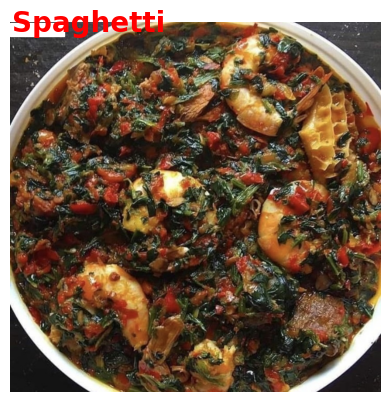

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/IMG_6700 - Olaolu Collins.jpeg'
display_image_with_prediction(image_path, model)
